In [ ]:
!pip install ultralytics
!pip install torchreid

In [ ]:
import os
import cv2
import csv
import shutil

# Paths (adjust these to match your Kaggle dataset paths)
frames_dir = "/kaggle/input/surveillance-for-retail-stores/tracking/train/02/img1"  # Folder containing sequence images
gt_file = "/kaggle/input/surveillance-for-retail-stores/tracking/train/02/gt/gt.txt"  # Ground-truth file path
output_dir = "/kaggle/working/cropped_output"  # Output folder to save cropped images

os.makedirs(output_dir, exist_ok=True)

prev_track_id = None  # To track the previous person ID
folder_counts = {}    # Dictionary to count number of images saved per person (track)

# Open and read the ground-truth file.
with open(gt_file, "r") as f:
    reader = csv.reader(f)
    # Check for a header row; if the first cell is non-numeric, assume header exists.
    header = next(reader)
    if not header[0].strip().isdigit():
        print("Header detected:", header)
    else:
        f.seek(0)
        reader = csv.reader(f)

    # Process each row in the GT file.
    # Expected columns: Frame, Track ID, X, Y, Width, Height, Confidence, Class, Visibility
    for row in reader:
        if len(row) < 6:
            continue  # Skip rows that don't have enough columns

        try:
            frame_num = int(row[0].strip())
            track_id = int(row[1].strip())+735  # Using track_id directly
            x = int(float(row[2].strip()))
            y = int(float(row[3].strip()))
            w = int(float(row[4].strip()))
            h = int(float(row[5].strip()))
        except Exception as e:
            print(f"Error parsing row {row}: {e}")
            continue

        # Only crop every 25th frame
        if frame_num % 25 != 0:
            continue        
        # If track id changes from previous row, print a message.
        if prev_track_id is not None and track_id != prev_track_id:
            print(f"Finished saving folder for person {prev_track_id}.")
        prev_track_id = track_id

        # Construct the frame image filename with zero padding (e.g., "000722.jpg")
        frame_filename = f"{frame_num:06d}.jpg"
        frame_path = os.path.join(frames_dir, frame_filename)
        if not os.path.exists(frame_path):
            print(f"Frame image {frame_path} does not exist. Skipping this row.")
            continue

        # Load the frame image.
        frame = cv2.imread(frame_path)
        if frame is None:
            print(f"Failed to read {frame_path}. Skipping.")
            continue

        # Get image dimensions.
        img_h, img_w = frame.shape[:2]

        # Clamp the coordinates so they don't exceed the image boundaries.
        x = max(0, x)
        y = max(0, y)
        x_end = min(x + w, img_w)
        y_end = min(y + h, img_h)
        if x >= img_w or y >= img_h or x_end <= x or y_end <= y:
            print(f"Invalid crop coordinates in frame {frame_num}. Skipping.")
            continue

        # Crop the region corresponding to the person.
        crop = frame[y:y_end, x:x_end]
        if crop.size == 0:
            continue

        # Create a directory for this person (track) if it doesn't exist.
        person_dir = os.path.join(output_dir, f"person_{track_id}")
        os.makedirs(person_dir, exist_ok=True)

        # Update folder count for this person.
        folder_counts[track_id] = folder_counts.get(track_id, 0) + 1

        # Save the cropped image; filename includes the frame number for reference.
        crop_filename = f"{frame_num:06d}_crop.jpg"
        crop_path = os.path.join(person_dir, crop_filename)
        cv2.imwrite(crop_path, crop)

# After processing all rows, check each folder's file count.
for track_id, count in folder_counts.items():
    person_dir = os.path.join(output_dir, f"person_{track_id}")
    if count < 10:
        print(f"Folder {person_dir} has only {count} images (<10); removing folder.")
        shutil.rmtree(person_dir)
    else:
        print(f"Folder {person_dir} kept with {count} images.")

if prev_track_id is not None:
    print(f"Finished saving folder for person {prev_track_id}.")

print(f"All crops have been processed and saved to {output_dir}")


In [5]:
import os
import re

# Path to the output directory generated by your cropping code.
output_dir = "/kaggle/working/cropped_output"

# List all subdirectories whose name starts with "person_"
folders = [d for d in os.listdir(output_dir)
           if os.path.isdir(os.path.join(output_dir, d)) and d.startswith("person_")]

# Function to extract numeric part from folder name "person_<number>"
def extract_number(folder_name):
    match = re.search(r"person_(\d+)", folder_name)
    return int(match.group(1)) if match else float('inf')

# Sort folders based on the extracted number
folders_sorted = sorted(folders, key=extract_number)

print("Original folder names (sorted):", folders_sorted)

# Rename folders using temporary names to avoid conflicts
temp_mapping = {}
for i, folder in enumerate(folders_sorted, start=1):
    current_path = os.path.join(output_dir, folder)
    temp_name = f"temp_person_{i}"
    temp_path = os.path.join(output_dir, temp_name)
    os.rename(current_path, temp_path)
    temp_mapping[temp_name] = i

# Now rename from temporary names to final sequential names.
for temp_name, new_index in temp_mapping.items():
    temp_path = os.path.join(output_dir, temp_name)
    final_name = f"person_{new_index}"
    final_path = os.path.join(output_dir, final_name)
    os.rename(temp_path, final_path)
    print(f"Renamed {temp_name} to {final_name}")

print("Folder renaming complete.")


Original folder names (sorted): ['person_1', 'person_3', 'person_5', 'person_6', 'person_7', 'person_8', 'person_9', 'person_10', 'person_11', 'person_12', 'person_13', 'person_14', 'person_15', 'person_16', 'person_17', 'person_18', 'person_19', 'person_20', 'person_21', 'person_22', 'person_23', 'person_24', 'person_25', 'person_26', 'person_27', 'person_28', 'person_29', 'person_30', 'person_32', 'person_33', 'person_34', 'person_35', 'person_37', 'person_42', 'person_43', 'person_44', 'person_45', 'person_46', 'person_47', 'person_48', 'person_49', 'person_50', 'person_51', 'person_52', 'person_57', 'person_58', 'person_59', 'person_60', 'person_61', 'person_62', 'person_64', 'person_65', 'person_66', 'person_67', 'person_74', 'person_75', 'person_77', 'person_78', 'person_79', 'person_81', 'person_82', 'person_83', 'person_84', 'person_85', 'person_86', 'person_87', 'person_88', 'person_95', 'person_96', 'person_97', 'person_98', 'person_99', 'person_100', 'person_101', 'person_10

In [4]:
import os
from PIL import Image
import random

def augment_image(image_path, output_path):
    # Open the original image
    img = Image.open(image_path)
    
    # Choose one random augmentation
    augmentation = random.choice(['zoom', 'flip', 'brightness', 'rotate','crop'])
    
    if augmentation == 'zoom':
        # Zoom in by 20% (scale up) or out by 20% (scale down)
        scale = random.choice([1.2, 0.8])
        width, height = img.size
        new_width = int(width * scale)
        new_height = int(height * scale)
        img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)
        # Center the image (if zoomed in, this effectively crops to original size)
        left = (new_width - width) // 2
        top = (new_height - height) // 2
        img = img.crop((left, top, left + width, top + height))
    
    elif augmentation == 'flip':
        # Flip left to right
        img = img.transpose(Image.FLIP_LEFT_RIGHT)
    
    elif augmentation == 'brightness':
        # Adjust brightness randomly between 0.7 (darker) and 1.3 (brighter)
        from PIL import ImageEnhance
        factor = random.uniform(0.7, 1.3)
        enhancer = ImageEnhance.Brightness(img)
        img = enhancer.enhance(factor)
    
    elif augmentation == 'rotate':
        # Rotate by random angle between -30 and 30 degrees
        angle = random.randint(-20, 20)
        img = img.rotate(angle, expand=False, resample=Image.Resampling.BICUBIC)
    elif augmentation == 'crop':
        width, height = img.size
        # Define crop size (e.g., 80% of original dimensions)
        crop_width = int(width * 0.8)
        crop_height = int(height * 0.8)
        # Randomly choose top-left corner
        left = random.randint(0, width - crop_width)
        top = random.randint(0, height - crop_height)
        right = left + crop_width
        bottom = top + crop_height
        # Crop the image
        img = img.crop((left, top, right, bottom))

    # Save the augmented image with '_augmented' suffix
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    new_name = f"{base_name}_augmented{os.path.splitext(image_path)[1]}"
    output_file = os.path.join(output_path, new_name)
    img.save(output_file)
    return output_file

def process_folder(main_folder):
    # Walk through all subdirectories
    for root, dirs, files in os.walk(main_folder):
        # Process only person_* folders
        if os.path.basename(root).startswith('person_'):
            for file in files:
                # Check if file is an image
                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                    image_path = os.path.join(root, file)
                    # Skip already augmented images
                    if '_augmented' not in file:
                        try:
                            augmented_path = augment_image(image_path, root)
                            #print(f"Processed: {image_path} -> {augmented_path}")
                        except Exception as e:
                            print(f"Error processing {image_path}: {str(e)}")

# Example usage
main_folder_path = "/kaggle/working/cropped_output"  # Replace with your folder path
process_folder(main_folder_path)
print(f"Done processing")

## Fine Tuning

Found 671 identities.
Epoch 1/20 Loss: 4.3515
Epoch 2/20 Loss: 2.1182
Epoch 3/20 Loss: 1.3431
Epoch 4/20 Loss: 0.9808
Epoch 5/20 Loss: 0.7832
Epoch 6/20 Loss: 0.6510
Epoch 7/20 Loss: 0.5629
Epoch 8/20 Loss: 0.4635
Epoch 9/20 Loss: 0.4181
Epoch 10/20 Loss: 0.3752
Epoch 11/20 Loss: 0.3363
Epoch 12/20 Loss: 0.3149
Epoch 13/20 Loss: 0.2926
Epoch 14/20 Loss: 0.2648
Epoch 15/20 Loss: 0.2794
No significant improvement. Patience counter: 1/3
Epoch 16/20 Loss: 0.2406
Epoch 17/20 Loss: 0.2372
Epoch 18/20 Loss: 0.2311
Epoch 19/20 Loss: 0.2199
Epoch 20/20 Loss: 0.1998
Best model saved to /kaggle/working/osnet_x0_25_market1501_finetuned.pt


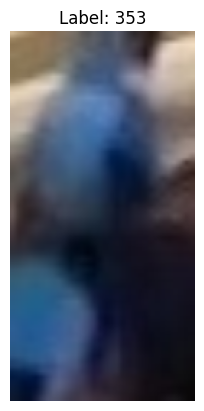

In [7]:
# Uncomment the following line in your Kaggle Notebook to install torchreid if not already installed
# !pip install torchreid

import os
from pathlib import Path
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchreid  # Import torchreid

# ---------------------------
# 1. Create a custom dataset class
class PersonReIDDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str or Path): Directory with subfolders per identity.
            transform (callable, optional): Transformations to apply to each image.
        """
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.samples = []  # list of tuples (image_path, label)
        # Each subfolder is assumed to be one person identity.
        person_dirs = sorted([d for d in self.root_dir.iterdir() if d.is_dir()])
        for label, person_dir in enumerate(person_dirs):
            # Iterate over all image files in the person's folder
            for file in sorted(person_dir.glob('*')):
                if file.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                    # img: label (person_num)
                    self.samples.append((file, label))
        # Randomize the sample order
        import random
        random.shuffle(self.samples)
                    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        # Apply the transform if provided
        if self.transform:
            img = self.transform(img)
        return img, label

# ---------------------------
# 2. Define transforms (no augmentation)
# We simply resize, convert to tensor, and normalize.
train_transforms = transforms.Compose([
    transforms.Resize((256, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# ---------------------------
# 3. Set paths and create DataLoader
# Update 'dataset_path' to the folder containing your person subfolders.
dataset_path = "/kaggle/working/cropped_output"  # Or use an input folder: "/kaggle/input/your_dataset"
dataset = PersonReIDDataset(root_dir=dataset_path, transform=train_transforms)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

# Determine the number of classes from the subfolder count.
num_classes = len([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])
print(f"Found {num_classes} identities.")

# ---------------------------
# 4. Build the OSNet_x0_75 model using torchreid
model = torchreid.models.build_model(
    name='osnet_x0_25',
    num_classes=num_classes,
    # Randomize weights
    pretrained=False  # We'll load a pre-trained checkpoint and then fine-tune.
)

# Load a pre-trained checkpoint (e.g., from MSMT17 or Market1501)
pretrained_checkpoint = "/kaggle/input/osnet_025_msmt17/pytorch/default/1/osnet_x0_25_market1501.pt"
state_dict = torch.load(pretrained_checkpoint, map_location='cpu', weights_only=True)

# Filter out classifier weights to avoid shape mismatches.
filtered_state_dict = {k: v for k, v in state_dict.items() if 'classifier' not in k}
model.load_state_dict(filtered_state_dict, strict=False)

# Replace the classifier to match your dataset's number of classes.
if isinstance(model.classifier, nn.Sequential):
    in_features = model.classifier[-1].in_features
else:
    in_features = model.classifier.in_features
model.classifier = nn.Linear(in_features, num_classes)

# ---------------------------
# 5. Move model to device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# ---------------------------
# 6. Set up loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

# ---------------------------
# 7. Training loop with early stopping
num_epochs = 20
early_stop_patience = 3   # Stop if no improvement for these many epochs
delta = 0.001            # Minimum decrease in loss to count as an improvement

best_loss = float('inf')
patience_counter = 0
best_model_state = None  # Save the best model state

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    
    epoch_loss = running_loss / len(dataset)
    print(f"Epoch {epoch+1}/{num_epochs} Loss: {epoch_loss:.4f}")
    
    # Check for improvement and update early stopping counter
    if best_loss - epoch_loss > delta:
        best_loss = epoch_loss
        best_model_state = model.state_dict()  # Save best model
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"No significant improvement. Patience counter: {patience_counter}/{early_stop_patience}")
        if patience_counter >= early_stop_patience:
            print("Early stopping triggered.")
            break

# ---------------------------
# 8. Save the best fine-tuned model
output_model_path = "/kaggle/working/osnet_x0_25_market1501_finetuned.pt"
if best_model_state is not None:
    torch.save(best_model_state, output_model_path)
    print(f"Best model saved to {output_model_path}")
else:
    torch.save(model.state_dict(), output_model_path)
    print(f"No improvement observed; current model saved to {output_model_path}")

# ---------------------------
# (Optional) Visualize one processed image from the training loader.
def imshow(img_tensor, title=""):
    img = img_tensor.cpu().clone()
    # Denormalize the image for display
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    img = img.clamp(0, 1)
    npimg = img.permute(1, 2, 0).numpy()
    plt.imshow(npimg)
    plt.title(title)
    plt.axis("off")
    plt.show()

# Display one processed image from the training loader.
for imgs, labels in train_loader:
    imshow(imgs[0], title=f"Label: {labels[0]}")
    break


In [ ]:
import cv2
import torch
import numpy as np
import os
import csv
import json
import matplotlib.pyplot as plt
from pathlib import Path
import torchvision
import torchvision.ops  # explicitly import ops
_ = torchvision.extension  # force the extension to load
from ultralytics import YOLO
from boxmot import BotSort
from boxmot.appearance.backbones.osnet import osnet_x0_25
# model = osnet_x0_25(num_classes=751)  # for example, Market-1501 has 751 classes
#
# ======== CUSTOM SETTINGS ========

# (1) Custom YOLOv8 model weights (update the path if needed)
model_weights_path = r"/kaggle/input/pretrained-yolov8/pytorch/default/1/custom_yolov8_retail_best.pt"

model = YOLO(model_weights_path)
# Optionally move YOLO to GPU if available:
device = torch.device('cpu')
model.to(device)  # ensure the underlying model is on the proper device

# (2) Custom OSNet weights with .pth extension (output)
custom_osnet_path = Path(r"/kaggle/input/osnet_025_msmt17/pytorch/default/1/osnet_x0_25_market1501.pt")

# ======== INPUT/OUTPUT SETUP ========

image_dir = r"/kaggle/input/surveillance-for-retail-stores/tracking/test/01/img1"
image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))])
if not image_files:
    raise ValueError("Error: No images found in the directory.")

output_video_path = "output_video_osnet_75_botsort.mp4"
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
first_frame = cv2.imread(os.path.join(image_dir, image_files[0]))
if first_frame is None:
    raise ValueError("Error: Could not load the first image.")
frame_height, frame_width = first_frame.shape[:2]
out = cv2.VideoWriter(output_video_path, fourcc, 25.0, (frame_width, frame_height))

print("Video writer dimensions:", (frame_width, frame_height))
output_csv = "tracking_output_osnet_75_msmt17.csv"
csv_file = open(output_csv, "w", newline='')
fieldnames = ["ID", "frame", "objects", "objective"]
writer = csv.DictWriter(csv_file, fieldnames=fieldnames, quoting=csv.QUOTE_ALL)
writer.writeheader()

# ======== INITIALIZE TRACKER ========
# Use GPU if available:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
tracker = BotSort(
    reid_weights=custom_osnet_path,
    device=device,
    half=False,
    track_high_thresh= 0.4,
    # TRACK MANAGEMENT
    track_buffer=60,          # keep track longer to ride out occlusions
    # MATCHING THRESHOLDS
    frame_rate= 25,
    match_thresh=0.80,        # demand very strong IoU/appearance match
    appearance_thresh=0.45,   # rely strongly on re-ID features
    with_reid=True,
    )




# ======== PROCESS EACH IMAGE FRAME ========
frame_counter = 0
for frame_idx, image_file in enumerate(image_files):
    frame_counter += 1
    frame_path = os.path.join(image_dir, image_file)
    frame = cv2.imread(frame_path)
    if frame is None:
        print(f"Error: Could not load {frame_path}. Skipping...")
        continue
    print("Processing frame:", frame_path, "with shape:", frame.shape)

    # --- Detection with custom YOLOv8 ---
    results = model(frame, verbose=False)
    if results and len(results) > 0 and results[0].boxes is not None:
        # Move detection results to CPU and convert to numpy arrays
        boxes = results[0].boxes.xyxy.cpu().numpy()  # shape: (N, 4)
        confidences = results[0].boxes.conf.cpu().numpy()  # shape: (N,)
    else:
        boxes = np.empty((0, 4))
        confidences = np.empty((0,))

    # Filter detections (confidence threshold >= 0.2)
    if confidences.size > 0:
        keep = confidences >= 0.0
        boxes = boxes[keep]
        confidences = confidences[keep]
    else:
        boxes = np.empty((0, 4))
        confidences = np.empty((0,))

    # --- Prepare detection array for BotSort ---
    if boxes.shape[0] > 0:
        dummy_class = np.zeros((boxes.shape[0], 1))
        scores = confidences.reshape(-1, 1)
        dets = np.hstack([boxes, scores, dummy_class])
    else:
        dets = np.empty((0, 6))

    # --- Update tracker ---
    res = tracker.update(dets, frame)

    # --- Annotate frame (tracker.plot_results modifies frame in-place) ---
    tracker.plot_results(frame, show_trajectories=True)
    annotated_frame = frame.copy()

    # --- Write tracking results to CSV ---
    objects_list = []
    if res is not None and res.shape[0] > 0:
        for det in res:
            x1, y1, x2, y2, track_id, conf, *_ = det
            width = x2 - x1
            height = y2 - y1
            obj = {
                'tracked_id': int(track_id),
                'x': float(x1),
                'y': float(y1),
                'w': float(width),
                'h': float(height),
                'confidence': conf  # BotSort does not output detection confidence
            }
            objects_list.append(obj)
    objects_str = json.dumps(objects_list)
    writer.writerow({
        "ID": frame_idx,
        "frame": float(frame_counter),
        "objects": objects_str,
        "objective": "tracking"
    })

    # --- Write the annotated frame to the video writer ---
    out.write(annotated_frame)

    # --- Display one sample frame inline using matplotlib ---
    # if frame_idx == 1:
    #     display_frame = cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB)
    #     plt.figure(figsize=(10, 6))
    #     plt.imshow(display_frame)
    #     plt.title("Sample Annotated Frame")
    #     plt.axis("off")
    #     plt.show()

# ======== RELEASE RESOURCES ========
csv_file.close()
out.release()
print(f"Tracking results saved to {output_csv}")
print(f"Output video saved to {output_video_path}")